In [6]:
#Necessary import
import gym
import random
import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from collections import deque

In [7]:
#CartPole environment import
env_name = "CartPole-v0"
env = gym.make(env_name)

#Show moves available and space dimensions
print("Observation space:", env.observation_space)
print("Action space:", env.action_space)

Observation space: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
Action space: Discrete(2)


In [8]:
#Neural network definition
class QNetwork():
    def __init__(self, state_dim, action_size):
        #Create tensorflow variable for environment caracteristics
        self.state_in = tf.placeholder(tf.float32, shape=[None, *state_dim])
        self.action_in = tf.placeholder(tf.int32, shape=[None])
        self.q_target_in = tf.placeholder(tf.float32, shape=[None])
        action_one_hot = tf.one_hot(self.action_in, depth=action_size)
        
        #Create layers of the network
        self.hidden1 = tf.layers.dense(self.state_in, 100, activation=tf.nn.relu)
        self.q_state = tf.layers.dense(self.hidden1, action_size, activation=None)
        self.q_state_action = tf.reduce_sum(tf.multiply(self.q_state, action_one_hot), axis=1)
        
        #Loss function instance
        self.loss = tf.reduce_mean(tf.square(self.q_state_action - self.q_target_in))
        
        #Create optimizer instance
        self.optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(self.loss)
    
    #Model update
    def update_model(self, session, state, action, q_target):
        feed = {self.state_in: state, self.action_in: action, self.q_target_in: q_target}
        session.run(self.optimizer, feed_dict=feed)
    
    #Run the network
    def get_q_state(self, session, state):
        q_state = session.run(self.q_state, feed_dict={self.state_in: state})
        return q_state

In [9]:
class ReplayBuffer():
    def __init__(self, maxlen):
        self.buffer = deque(maxlen=maxlen)
        
    def add(self, experience):
        self.buffer.append(experience)
        
    def sample(self, batch_size):
        sample_size = min(len(self.buffer), batch_size)
        samples = random.choices(self.buffer, k=sample_size)
        return map(list, zip(*samples))

In [10]:
#Deep Q-Learning agent
class DQNAgent():
    def __init__(self, env):
        #Istance of the environment caracteristics
        self.state_dim = env.observation_space.shape
        self.action_size = env.action_space.n
        
        #Instance of Q-Learning Network
        self.q_network = QNetwork(self.state_dim, self.action_size)
        
        #Istance of the replay buffer
        self.replay_buffer = ReplayBuffer(maxlen=10000)
        
        #Costant of the agent
        self.gamma = 0.99
        self.eps = 1.0
        
        #Create and run session
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
    
    
    #Function that take the action to perform to the environment
    def get_action(self, state):
        q_state = self.q_network.get_q_state(self.sess, [state])
        action_greedy = np.argmax(q_state)
        action_random = np.random.randint(self.action_size)
        action = action_random if random.random() < self.eps else action_greedy
        return action
    
    #Function that want to update the agent after one action performed
    def train(self, state, action, next_state, reward, done):
        self.replay_buffer.add((state, action, next_state, reward, done))
        states, actions, next_states, rewards, dones = self.replay_buffer.sample(50)
        q_next_states = self.q_network.get_q_state(self.sess, next_states)
        q_next_states[dones] = np.zeros([self.action_size])
        q_targets = rewards + self.gamma * np.max(q_next_states, axis=1)
        self.q_network.update_model(self.sess, states, actions, q_targets)
        
        if done: self.eps = max(0.1, 0.99*self.eps)
    
    def __del__(self):
        self.sess.close()

In [11]:
#Agent instance
agent = DQNAgent(env)

#Episodes number
num_episodes = 400
total_reward_array=[]

#Each iteration represent one episode
for ep in range(num_episodes):
    #Reset environment
    state = env.reset()
    
    total_reward = 0
    done = False
    while not done:
        #Take action from agent and permorm it
        action = agent.get_action(state)
        next_state, reward, done, info = env.step(action)
        
        #Update agent 
        agent.train(state, action, next_state, reward, done)
        
        #Show environment state
        env.render()
        
        total_reward += reward
        state = next_state
     
    #Show episode total reward
    total_reward_array.append(total_reward)
    print("Episode: {}, total_reward: {:.2f}".format(ep, total_reward))

C:\Users\Gabriella Bravaccini\anaconda3\lib\site-packages\tensorflow\python\keras\legacy_tf_layers\core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
C:\Users\Gabriella Bravaccini\anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1692: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Episode: 0, total_reward: 37.00
Episode: 1, total_reward: 14.00
Episode: 2, total_reward: 50.00
Episode: 3, total_reward: 17.00
Episode: 4, total_reward: 25.00
Episode: 5, total_reward: 26.00
Episode: 6, total_reward: 22.00
Episode: 7, total_reward: 35.00
Episode: 8, total_reward: 17.00
Episode: 9, total_reward: 23.00
Episode: 10, total_reward: 13.00
Episode: 11, total_reward: 18.00
Episode: 12, total_reward: 16.00
Episode: 13, total_reward: 28.00
Episode: 14, total_reward: 18.00
Episode: 15, total_reward: 35.00
Episode: 16, total_reward: 23.00
Episode: 17, total_reward: 17.00
Episode: 18, total_reward: 19.00
Episode: 19, total_reward: 32.00
Episode: 20, total_reward: 27.00
Episode: 21, total_reward: 18.00
Episode: 22, total_reward: 20.00
Episode: 23, total_reward: 33.00
Episode: 24, total_reward: 122.00
Episode: 25, total_reward: 41.00
Episode: 26, total_reward: 38.00
Episode: 27, total_reward: 17.00
Episode: 28, total_reward: 33.00
Episode: 29, total_reward: 18.00
Episode: 30, total_

In [12]:
#Close environment
env.close()

In [13]:
#Necessary import to plot total reward results
import seaborn as sns
import matplotlib.pyplot as plt

<function matplotlib.pyplot.show(close=None, block=None)>

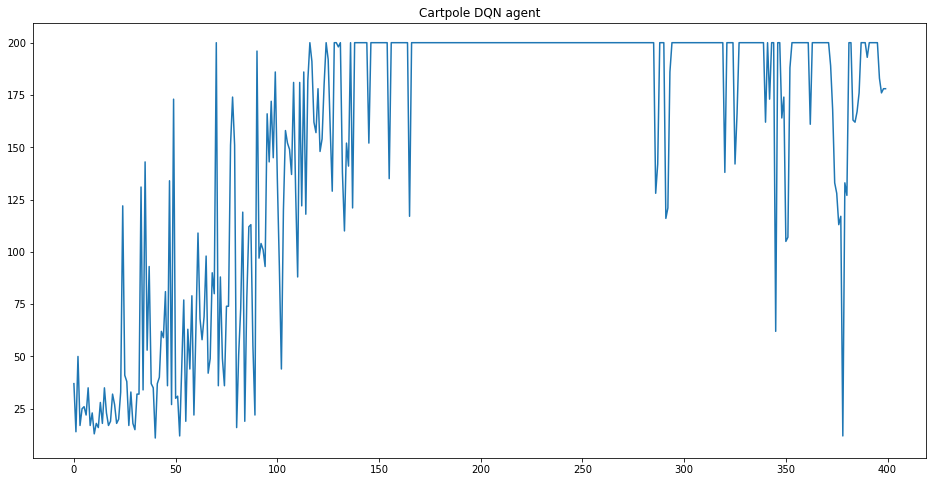

In [14]:
#Plot total reward results
fig, ax = plt.subplots(figsize=(16,8))
sns.lineplot(x=range(0,400), y= total_reward_array, ax=ax)
plt.title('Cartpole DQN agent')
plt.show